# Modelling irregular bodies shape via ANNs
In this notebook we explore the possibility to use ANNs to represent the generic shape and density of an irregular body and be trained to reproduce a known gravitational potential field.

To get statically stable asteroids we use results from MPIA work by Francesco Biscani obtained during simulation of protoplanetary formation made by large n-body simulations. Data are included as a submodule in the git project.

To run this notebook create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib
 conda activate geodesyann
 conda install -c open3d-admin open3d
 pip install sobol_seq
```

And you will need pytorch (CPU is enough) for the ANN part


In [1]:
# core stuff
import h5py
import numpy as np
import scipy
from copy import deepcopy

# pytorch
from torch import nn
import torch
# For debugging and development purposes this is now set to float64 ... change for speed on GPUs
torch.set_default_tensor_type(torch.DoubleTensor)

# misc
import sobol_seq
from scipy import integrate

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Loading and visualizing the ground truth asteroid (a point cloud)

These are interesting clusters to study.

- sample_01 -> cluster_2400
- sample_02 -> cluster_5486
- sample_03 -> cluster_2284
- sample_04 -> cluster_7315
- sample_05 -> cluster_3847
- sample_06 -> cluster_6137
- sample_07 -> cluster_2441
- sample_08 -> cluster_1970
- sample_09 -> cluster_1896

In [2]:
# We import the data from MPIA containing pseudo-stable asteroid shapes
sample = "sample_02"
f = h5py.File("sample_vis_data/" + sample + "/state_8741.hdf5",'r')
f2 = h5py.File('sample_vis_data/sample_02/global.hdf5', 'r')

In [3]:
# The file state_ ... contains the positions of all particles as well as the indices
# of those belonging to a cluster. Here we extract the largest ones.
dims = [(len(f[cluster][()]), cluster) for cluster in f.keys() if 'cluster' in cluster]
largest_clusters = sorted(dims,reverse=True)

In [4]:
# We have ordered the largest asteroids, we now extract positions for one in particular
rank = 1
#cluster_name = largest_clusters[rank][1]
# Or we directly name the one we want
cluster_name = "cluster_5486"
print("Target: ", cluster_name)
# The particles idxs for this cluster
idx = f["cluster_5486"][()]
# The particle radius
radius = f2['radius'][()]
# Particle positions
x_raw = f['x'][()][idx]
y_raw = f['y'][()][idx]
z_raw = f['z'][()][idx]
print("Diameter: ", 2 * radius)

Target:  cluster_5486
Diameter:  0.00043088693800637674


In [5]:
from sklearn.neighbors import NearestNeighbors
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x_raw, np.append(y_raw,z_raw))
point_cloud = point_cloud.reshape((3,len(x_raw)))
point_cloud = np.transpose(point_cloud)

nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(point_cloud)
distances, indices = nbrs.kneighbors(point_cloud)

print("Minimum distance between particles: ", min(distances[:,1]))
print("Maximum distance between particles: ", max(distances[:,1]))

# We take out particles that are not "touching" at least two neighbours
unstable_points = np.where(distances[:, 3]> 2 * radius * 1.1)[0]
print("Number of unstable points: ", len(unstable_points))
x = np.delete(x_raw, unstable_points, 0)
y = np.delete(y_raw, unstable_points, 0)
z = np.delete(z_raw, unstable_points, 0)


Minimum distance between particles:  0.00042332728057018366
Maximum distance between particles:  0.0005034108274804448
Number of unstable points:  5


In [6]:
# We subtract the mean so that the origin is the center of figure
x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)
# We normalize so that the axes are at most one
max_value = max([max(abs(it)) for it in [x,y,z]])
x = x / max_value
y = y / max_value
z = z / max_value
plot_radius = radius /  max_value  * 3000
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x, np.append(y,z))
point_cloud = point_cloud.reshape((3,len(x)))
point_cloud = np.transpose(point_cloud)
point_cloud = torch.tensor(point_cloud)

### Visualization via matplotlib

<IPython.core.display.Javascript object>


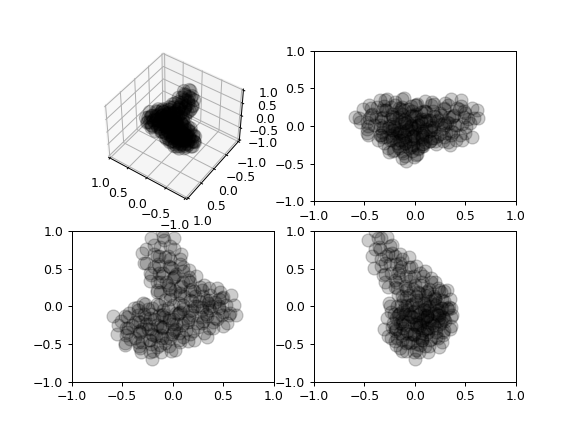

(-1.0, 1.0)

In [7]:
fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')

# And visualize the masses
ax.scatter(x, y, z, color = 'k', s = plot_radius/2, alpha=0.2)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(elev=45., azim=125.)

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, color = 'k', s = plot_radius/2, alpha=0.2)
ax2.set_xlim([-1,1])
ax2.set_ylim([-1,1])

ax3 = fig.add_subplot(223)
ax3.scatter(x, z, color = 'k', s = plot_radius/2, alpha=0.2)
ax3.set_xlim([-1,1])
ax3.set_ylim([-1,1])

ax4 = fig.add_subplot(224)
ax4.scatter(y, z, color = 'k', s = plot_radius/2, alpha=0.2)
ax4.set_xlim([-1,1])
ax4.set_ylim([-1,1])

### Visualization via open3d

WARNINGS: Makes only sense for convex shapes.

In [9]:
import numpy as np
import open3d as o3d

# We color the points w.r.t. their distance to the center
color = [np.linalg.norm([point]) for point in point_cloud.numpy()] 
colors = np.exp(-np.array(color))
colors = np.append(np.append(colors, colors), colors).reshape((3, len(color))).transpose()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.colors = o3d.utility.Vector3dVector(colors)


hull, _ = pcd.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([pcd, hull_ls])

# Computing the gravitational potential of the ground truth the asteroid
The Canvendish constant is not included (or $G=1$), so that we have:
$$
U_L = - \sum_{i=1}^N \frac{m_i}{|\mathbf x - \mathbf r_i|}
$$
where, assuming the asteroid with a unitary mass $m_i = 1/N$, hence:
$$
U_L = - \frac 1N \sum_{i=1}^N \frac{1}{|\mathbf x - \mathbf r_i|}
$$

In [8]:
# This will create the labels for the supervised learning
def U_L(target_points, point_cloud):
    retval=torch.empty(len(target_points),1)
    for i, target_point in enumerate(target_points):
        retval[i] = torch.mean(1./torch.norm(torch.sub(point_cloud,target_point), dim=1))
    return - retval 

In [9]:
target_points = torch.rand(100,3)

In [10]:
%timeit U_L(target_points, point_cloud)

17.4 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Representing an asteroid via a neural network


## 1 - Instantiating the network
The networks inputs are the cartesian coordinates of a point in the unit cube, encoded via some transformation

In [11]:
# All encodings work taking as input a tensor (N, 3) containing the cartesian coordinates of N points
# and returning a tensor of (N, M) that can be used as input to the ANN

# Encoding N.1 (directional encoding):
# x = [x,y,z] is encoded as [ix, iy, iz, r]
class directional_encoding:
    def __init(self):
        self.n_inputs = 4
        self.name = "directional_encoding"
    # sp: sampled points
    def __call__(self, sp):
        unit = sp / torch.norm(sp,dim=1).view(-1,1)
        return torch.cat((unit, torch.norm(sp,dim=1).view(-1,1)), dim=1)

# Encoding N.2 (positional encoding):
# x = [x,y,z] is encoded as [sin(pi x), sin(pi y), sin(pi z), cos(pi x), cos(pi y), cos(pi z), sin(2 pi x), ....]
class positional_encoding:
    def __init__(self, N):
        self.n_inputs = 6 * N
        self.name = "positional_encoding_" + str(N)
    def __call__(self, sp):
        retval = torch.cat((torch.sin(np.pi * sp).view(-1,3),torch.cos(np.pi * sp).view(-1,3)), dim=1)
        for i in range(1, self.n_inputs // 6):
            retval = torch.cat((retval, torch.sin(2**i*np.pi * sp).view(-1,3),torch.cos(2**i*np.pi * sp).view(-1,3)), dim=1)
        return retval

# Encoding N.3 (direct encoding):
class direct_encoding:
    def __init__(self):
        self.n_inputs = 3
        self.name = "direct_encoding"
    def __call__(self, sp):
        return sp
        
# Encoding N.4 (spherical coordinates). These can be used with positional encoding to create effectively harmonics
class spherical_coordinates:
    def __init__(self):
        self.n_inputs = 3
        self.name = "spherical_coordinates"
    def __call__(self, sp):
        phi = torch.atan2(sp[:,1], sp[:,0]) / np.pi
        r = torch.norm(sp, dim=1)
        theta = torch.div(sp[:,2], r)
        return torch.cat((r.view(-1,1), phi.view(-1,1), theta.view(-1,1)), dim=1)
    

In [17]:
# Encoding choosen
encoding = direct_encoding()

# Network initialization scheme (note that if xavier uniform is used all outputs will start at, roughly 0.5)
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.uniform_(m.bias.data, -0.0, 0.0)

# Network architecture. Note that the dimensionality of the first linear layer must match the output
# of the encoding chosen
n_neurons = 100
model = nn.Sequential(
          nn.Linear(encoding.n_inputs,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,1),
          nn.Sigmoid(),
        )

# Applying our weight initialization
_  = model.apply(weights_init)

In [28]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
#model.load_state_dict(torch.load("models/" + sample + "_" + cluster_name + "_" + encoding.name + ".mdl"))

## Visualizing an asteroid represented by the network
The network output is the density in the unit cube. It is, essentially, a three dimensional function and as such it is difficult to plot. 

### Approach 1: plotting a grid of points colored with the rho value

<IPython.core.display.Javascript object>


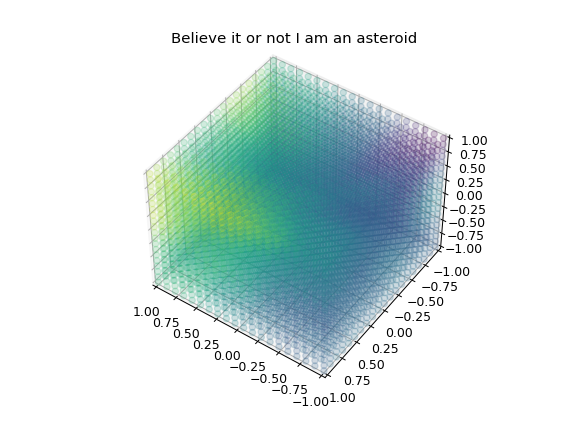

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [19]:
def plot_asteroid1(model, encoding, N=20, bw = False, ax = None, alpha = 0.2, views_2d = False):
    # We create the grid
    x = torch.linspace(-1,1,N)
    y = torch.linspace(-1,1,N)
    z = torch.linspace(-1,1,N)
    X, Y, Z = torch.meshgrid((x,y,z))

    # We compute the density on the grid points (no gradient as its only for plotting)
    nn_inputs = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)), dim=1)
    nn_inputs = encoding(nn_inputs)
    RHO = model(nn_inputs).detach()
 
    # And we plot it
    fig = plt.figure()
    if views_2d:
        ax = fig.add_subplot(221, projection='3d')
    else:
        ax = fig.add_subplot(111, projection='3d')
    if bw:
        col = torch.cat((1-RHO, 1-RHO, 1-RHO, RHO), dim=1)
        alpha = None
    else:
        col = RHO
    
    ax.scatter(X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1), marker='.', c=col, s=100, alpha = alpha)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.view_init(elev=45., azim=125.)
    
    if views_2d:
        ax2 = fig.add_subplot(222)
        ax2.scatter(X.reshape(-1,1)[:,0], Y.reshape(-1,1)[:,0], marker='.', c=col, s=100, alpha=alpha)
        ax2.set_xlim([-1,1])
        ax2.set_ylim([-1,1])

        ax3 = fig.add_subplot(223)
        ax3.scatter(X.reshape(-1,1)[:,0], Z.reshape(-1,1)[:,0], marker='.', c=col, s=100, alpha=alpha)
        ax3.set_xlim([-1,1])
        ax3.set_ylim([-1,1])

        ax4 = fig.add_subplot(224)
        ax4.scatter(Y.reshape(-1,1)[:,0], Z.reshape(-1,1)[:,0], marker='.', c=col, s=100, alpha=alpha)
        ax4.set_xlim([-1,1])
        ax4.set_ylim([-1,1])
    
    return fig
       
fig = plot_asteroid1(model, encoding, bw = False, views_2d=False)
plt.title("Believe it or not I am an asteroid")

### Approach 2: considering rho as a probability density function and sampling points from it

<IPython.core.display.Javascript object>


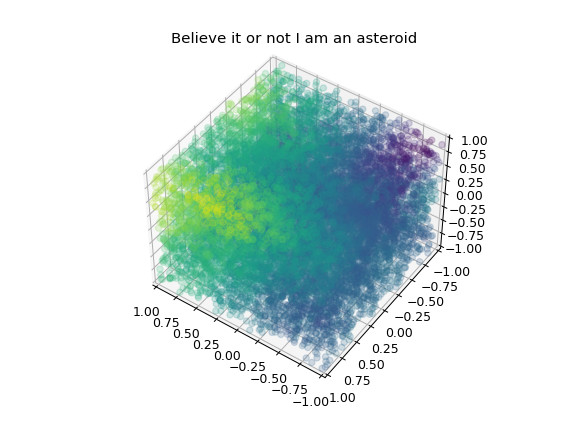

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [20]:
# Rejection sampling
def plot_asteroid2(model, encoding, N=30**3, views_2d = False, bw = False, alpha = 0.2, crop_p = 1e-2):
    points = torch.rand(N, 3) *2 -1
    nn_inputs = encoding(points)
    RHO = model(nn_inputs).detach()
    mask = RHO > (torch.rand(N,1) + crop_p)
    RHO = RHO[mask]
    points = [[it[0].item(), it[1].item(), it[2].item()] for it,m in zip(points, mask) if m] 
    points = torch.tensor(points)
    fig = plt.figure()
    if views_2d:
        ax = fig.add_subplot(221, projection='3d')
    else:
        ax = fig.add_subplot(111, projection='3d')
    if bw:
        col = 'k'
    else:
        col = RHO
    # And we plot it
    ax.scatter(points[:,0], points[:,1], points[:,2], marker='.', c=col, s=100, alpha=alpha)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.view_init(elev=45., azim=125.)

    
    if views_2d:
        ax2 = fig.add_subplot(222)
        ax2.scatter(points[:,0], points[:,1], marker='.', c=col, s=100, alpha=alpha)
        ax2.set_xlim([-1,1])
        ax2.set_ylim([-1,1])

        ax3 = fig.add_subplot(223)
        ax3.scatter(points[:,0], points[:,2], marker='.', c=col, s=100, alpha=alpha)
        ax3.set_xlim([-1,1])
        ax3.set_ylim([-1,1])

        ax4 = fig.add_subplot(224)
        ax4.scatter(points[:,1], points[:,2], marker='.', c=col, s=100, alpha=alpha)
        ax4.set_xlim([-1,1])
        ax4.set_ylim([-1,1])
    
    return fig
    
plot_asteroid2(model, encoding)
plt.title("Believe it or not I am an asteroid")

# Note that if the network is initialized by xavier the density will roughly be 0.5 everywhere so rejection sampling
# will also create a uniform cloud of points

## Computing the gravitational potential of the asteroid ANN model wia Monte Carlo methods
The Network represents the mass density $\rho$, but the potential field created by it is given by the integral:
$$
U_P = - \int_V \frac\rho {|\mathbf r-\mathbf x|}  dV 
$$
where the volume V is the cube $[-1,1]^3$. 

We thus must approximate the above integral, and to do so we use the Monte Carlo formula:
$$
\int_V f(\mathbf x) dv = \frac 1N \sum_i \frac{f(\mathbf x_i)}{g(\mathbf x_i)}
$$
where g is the pdf of the distribution we sample $x_i$ from.

Applying the formula above to our integral we get:

- Naive Monte Carlo
$$
U_P(\mathbf r) \approx \frac 8N \sum_i \frac {\rho_i}{|\mathbf r-\mathbf x_i|} 
$$


where we assumed that $g$ was the uniform random distribution.

Improvements to the above strategy are often a) the use of low-discrepancy seqeunces, b) importance sampling and c) MCMC methods. While a) is indeed applicable, b) and c) seem problematic in our case.

In [21]:
# We generate a low-discrepancy sequence here and keep it in memory (generating it requires some CPU time)
sobol_points = sobol_seq.i4_sobol_generate(3, 200000)

# Naive Montecarlo
def U_Pmc(target_points, model, N = 3000):
    # We generate randomly points in the [-1,1]^3 bounds
    sample_points = torch.rand(N,3) * 2 - 1
    nn_inputs = encoding(sample_points)
    rho = model(nn_inputs)
    retval=torch.empty(len(target_points),1)
    # Only for the points inside we accumulate the integrand (MC method)
    for i, target_point in enumerate(target_points):
        retval[i] = torch.sum(rho/torch.norm(target_point - sample_points, dim=1).view(-1,1)) / N
    return  - 8 * retval

# Low-discrepancy Montecarlo
def U_Pld(target_points, model, N = 3000, noise = 1e-5):
    # We generate randomly points in the [-1,1]^3 bounds
    sample_points = torch.tensor(sobol_points[:N,:] * 2 - 1) + torch.rand(N,3) * noise
    nn_inputs = encoding(sample_points)
    rho = model(nn_inputs)
    retval=torch.empty(len(target_points),1)
    # Only for the points inside we accumulate the integrand (MC method)
    for i, target_point in enumerate(target_points):
        retval[i] = torch.sum(rho/torch.norm(target_point - sample_points, dim=1).view(-1,1)) / N
    return  - 8 * retval

# Importance sampling could be a third approach to use here and benchmark .. so far we did not have success
# in assembling an algorithm able to

In [22]:
# Here we create some target points where to compute the potential
N_try = 1
target_points = (torch.rand(N_try,3)*2-1)*1.1
a = torch.logical_and((target_points[:,0]>-1),(target_points[:,0]<1))
b = torch.logical_and((target_points[:,1]>-1),(target_points[:,1]<1))
c = torch.logical_and((target_points[:,2]>-1),(target_points[:,2]<1))
d = torch.logical_and(torch.logical_or(a,b), c)
target_points=target_points[d]
print("Target point is: ", target_points)

Target point is:  tensor([[-0.8202, -0.3830, -0.8164]])


#### We time the MC methods

In [23]:
%timeit U_Pld(target_points, model, N = 10000)

45.3 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%timeit U_Pmc(target_points, model, N = 10000)

46.4 ms ± 3.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### We study their convergence
Note that results may be different according to how discontinuous and ill is the function $\rho$ representaed by the network and to what ground truth we set

In [25]:
# We use as ground truth the value computed by the low-discrepancy method for 200000 points
ground_truth = U_Pld(target_points, model, N = 200000).detach()
# Or, uncomment these lines to attempt quadrature
#def f(x,y,z):
#    nn_inputs = encoding(torch.tensor([[x,y,z]])) 
#    return model(nn_inputs).detach().item()
#
#res, err = integrate.tplquad(f, -1, 1, lambda x: -1, lambda x: 1, lambda x, y: -1, lambda x, y: 1, epsabs = 1e-5, epsrel=1e-5)
print("Ground truth is: ", ground_truth.item())

Ground truth is:  -3.338184077611654


In [49]:
# This is slow, run only to generate again the plot below
grid = range(1000, 60000, 100)
mc = []
for g in grid:
    mc.append(torch.abs(U_Pmc(target_points, model, N = g).detach()-ground_truth))

In [50]:
# This is slow, run only to generate again the plot below
ld = []
for g in grid:
    ld.append(torch.abs(U_Pld(target_points, model, N = g, noise=1e-5).detach()-ground_truth))

<IPython.core.display.Javascript object>


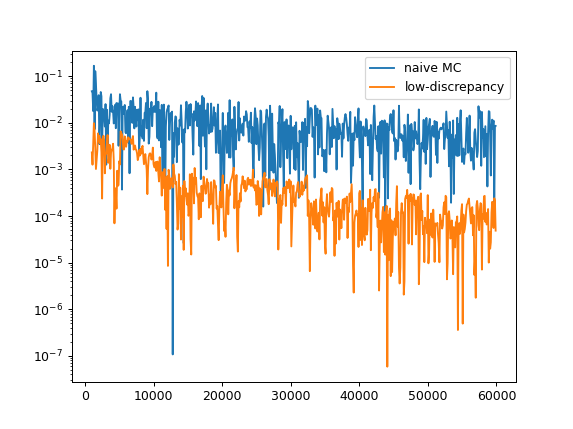

In [52]:
# We plot the results
fig = plt.figure()
plt.semilogy(grid, mc, label = "naive MC")
plt.semilogy(grid, ld, label = "low-discrepancy")
plt.legend()

# Note that we do not have a proper ground truth here to compare with, nevertheless the trend seems clear.

# Training The ANN to match the ground truth potential

Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [26]:
# Here we set some details of the training
# This loss function adds a normalization constant to the network outputs so
# that the MSE is minimized. Like this it is only the mass distribution to count
# not its absolute value. Seems on paper a great idea, everybody should do it .. but does it work?
def normalized_loss(predicted, labels):
    c = sum(torch.mul(labels, predicted))/sum(torch.pow(predicted,2))
    return sum(torch.pow(torch.sub(labels,c*predicted),2)) / len(labels)

# Here we set the loss function
#loss_fn = torch.nn.MSELoss()
loss_fn = normalized_loss

# Here we set the choosen Monte Carlo method
mc_method = U_Pld

learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
# This is the main training loop
for i in range(5000):
    # At each new epoch we generate new points (its like a new batch), but we make sure
    # they are outside the unit cube
    targets = (torch.rand(100,3)*2-1)*1.1
    a = torch.logical_and((targets[:,0]>-1),(targets[:,0]<1))
    b = torch.logical_and((targets[:,1]>-1),(targets[:,1]<1))
    c = torch.logical_and((targets[:,2]>-1),(targets[:,2]<1))
    d = torch.logical_and(torch.logical_or(a,b), c)
    targets=targets[d]
    labels = U_L(targets, point_cloud)
    
    # Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
    predicted = mc_method(targets, model, N=200000)
    loss = loss_fn(predicted, labels)
    print(i, loss.item())
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 6.003466051883213e-05
1 3.9814523340445485e-05


<IPython.core.display.Javascript object>


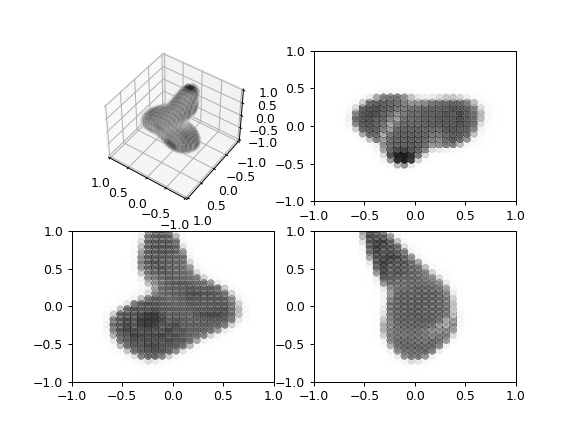

In [31]:
fig = plot_asteroid1(model, encoding, N=30, bw=True, views_2d=True)
#plt.title("Do I look like an asteroid now?")

#### Saving the model

In [102]:
# Uncomment to save to models/cluster_xxxx
torch.save(model.state_dict(), "models/" + sample + "_" + cluster_name + "_" + encoding.name + ".mdl")

# TODO list:

* Code efficiency -> move to GPU and make training scalable to more sample points / mc points.
* MC integration -> importance sampling maybe?
* Network architecture -> study different encodings
* How to visualize and interpret the results quantitatively.
* Propagate trajectories around the asteroids (ground truth and trained).
* Incorporate visual cues.
* Training with gravity rather than potential?
* What happens for non uniform bodies?